[View in Colaboratory](https://colab.research.google.com/github/NicknameSoHard/Open_course_ML/blob/master/ML_homework_4.ipynb)

Источник задания: http://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_russian/assignments_demo/assignment04_habr_popularity_ridge.ipynb

**Приступим:** импортируем необходимые библиотеки и скачаем данные

In [200]:
!mkdir drive/
!mkdir drive/Open_course_ML/

!wget "https://drive.google.com/uc?export=download&id=1Ml74UbTLy706MyMcK_QSILBRDP2jDaI3" -P drive/Open_course_ML -O drive/Open_course_ML/howpop_train.csv
!wget "https://drive.google.com/uc?export=download&id=1V1Rer5EaEXEMk_F_TIhakgf_Jct_RYdu" -P drive/Open_course_ML -O drive/Open_course_ML/howpop_test.csv
!wget "https://drive.google.com/uc?export=download&id=10u-0sS1RRPgC86Gayza2b7t2V6s8Q7ti" -P drive/Open_course_ML -O drive/Open_course_ML/habr_sample_submission.csv

mkdir: cannot create directory ‘drive/’: File exists
mkdir: cannot create directory ‘drive/Open_course_ML/’: File exists
--2018-07-15 10:34:21--  https://drive.google.com/uc?export=download&id=1Ml74UbTLy706MyMcK_QSILBRDP2jDaI3
Resolving drive.google.com (drive.google.com)... 74.125.195.113, 74.125.195.101, 74.125.195.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/aj78pmbas3aen7p0td8q8et309mnhme5/1531648800000/10325804979824545333/*/1Ml74UbTLy706MyMcK_QSILBRDP2jDaI3?e=download [following]
--2018-07-15 10:34:22--  https://doc-00-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/aj78pmbas3aen7p0td8q8et309mnhme5/1531648800000/10325804979824545333/*/1Ml74UbTLy706MyMcK_QSILBRDP2jDaI3?e=download
Resolving doc-00-9c-docs.googleusercontent.com (doc-00-9c-docs.go

In [0]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import scipy

%matplotlib inline
from matplotlib import pyplot as plt

Скачайте [данные](https://www.kaggle.com/c/howpop-habrahabr-favs-lognorm/data) соревнования.

In [0]:
train_df = pd.read_csv('drive/Open_course_ML/howpop_train.csv')
test_df  = pd.read_csv('drive/Open_course_ML/howpop_test.csv')

In [203]:
train_df.head(5).T

,0,1,2,3,4
url,https://habrahabr.ru/post/18284/,https://habrahabr.ru/post/18285/,https://habrahabr.ru/post/18286/,https://habrahabr.ru/post/18291/,https://geektimes.ru/post/18294/
domain,habrahabr.ru,habrahabr.ru,habrahabr.ru,habrahabr.ru,geektimes.ru
post_id,18284,18285,18286,18291,18294
published,2008-01-01 18:19:00,2008-01-01 18:30:00,2008-01-01 18:34:00,2008-01-02 01:32:00,2008-01-02 14:34:00
author,@Tapac,@DezmASter,@DezmASter,@Taoorus,@dennydo
flow,develop,design,design,design,NaN
polling,False,False,False,False,False
content_len,4305,7344,8431,5662,3706
title,Новогодний подарок блоггерам — WordPress 2.3.2,"Сумасшедшие яйца, или сервис для отслеживания ...","Сумасшедшие яйца, или сервис для отслеживания ...","Сглаживание шрифтов, и субпиксельная отрисовка",Почему мне не нравится iPhone
comments,0,1,47,102,230


In [204]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

Убедимся, что данные отсортированы по признаку `published`

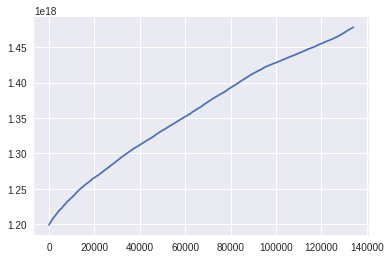

In [205]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

**Чтобы ответить на вопросы 1 и 2, можно использовать [pandas.DataFrame.corr()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html), [pandas.to_datetime()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) и [pandas.Series.value_counts()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html)**

<font color='red'>Вопрос 1.</font> Есть ли в train_df признаки, корреляция между которыми больше 0.9? Обратите внимание, именно различные признаки - корреляция признака с самим собой естественно больше 0.9 :)
- да
- нет
- не знаю

In [206]:
train_df.corr()

,post_id,polling,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
post_id,1.000000,0.081628,0.241384,-0.147763,0.089313,0.132385,-0.187885,-0.235594,-0.010376,-0.005845,-0.001605
polling,0.081628,1.000000,-0.003337,0.042605,0.006882,0.025660,-0.033505,0.027116,-0.003523,-0.036385,0.071417
content_len,0.241384,-0.003337,1.000000,-0.023544,0.308194,0.204101,0.068779,-0.078686,0.246063,0.356481,0.073132
comments,-0.147763,0.042605,-0.023544,1.000000,0.164166,0.290035,0.613961,0.457638,0.349568,0.278942,0.662740
favs,0.089313,0.006882,0.308194,0.164166,1.000000,0.634304,0.416241,0.062877,0.456097,0.587982,0.263239
views,0.132385,0.025660,0.204101,0.290035,0.634304,1.000000,0.396849,0.128654,0.585105,0.406782,0.326427
votes_plus,-0.187885,-0.033505,0.068779,0.613961,0.416241,0.396849,1.000000,0.464168,0.414232,0.449712,0.525081
votes_minus,-0.235594,0.027116,-0.078686,0.457638,0.062877,0.128654,0.464168,1.000000,0.146609,0.088226,0.355458
views_lognorm,-0.010376,-0.003523,0.246063,0.349568,0.456097,0.585105,0.414232,0.146609,1.000000,0.688811,0.546530
favs_lognorm,-0.005845,-0.036385,0.356481,0.278942,0.587982,0.406782,0.449712,0.088226,0.688811,1.000000,0.479476


In [207]:
answer = []
correlation = train_df.corr()
for coll in correlation.values:
  for cell in coll:
    if cell > 0.9 and cell < 1.0:
      answer.append(cell)
      
if answer == []:
  print('Значительных корреляций не обнаружено')
else:
  print(answer)

Значительных корреляций не обнаружено


In [0]:
#Преобразуем дату и время из строки
train_df['published'] = pd.to_datetime(train_df.published, yearfirst = True)
test_df['published'] = pd.to_datetime(test_df.published, yearfirst = True)

<font color='red'>Вопрос 2.</font> В каком году было больше всего публикаций? (Рассматриваем train_df)
- 2014
- 2015
- 2016
- 2017

In [209]:
train_df['year'] = [ dt.year for dt in train_df.published ]
train_df['year'].value_counts()

2015    23452
2016    16316
2014    16180
2012    15972
2013    15537
2011    15063
2010    13091
2009    10783
2008     7743
Name: year, dtype: int64

## Разбиение на train/valid
Используем только признаки 'author', 'flow', 'domain' и 'title'

In [0]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [211]:
len(train_df), train_size

(134137, 93895)

In [0]:
X, y = train_df.loc[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной

X_test = test_df.loc[:, features]

In [0]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

## Применение TfidfVectorizer

**TF-IDF** (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе, и обратно пропорционален частоте употребления слова в других документах коллекции. [Подробнее в источнике](https://ru.wikipedia.org/wiki/TF-IDF)

TfidfVectorizer преобразует тексты в матрицу TF-IDF признаков.

**Основные параметры TfidfVectorizer в sklearn:**
- **min_df** - при построении словаря слова, которые встречаются *реже*, чем указанное значение, игнорируются
- **max_df** - при построении словаря слова, которые встречаются *чаще*, чем указанное значение, игнорируются
- **analyzer** - определяет, строятся ли признаки по словам или по символам (буквам)
- **ngram_range** - определяет, формируются ли признаки только из отдельных слов или из нескольких слов (в случае с analyzer='char' задает количество символов). Например, если указать analyzer='word' и ngram_range=(1,3),то признаки будут формироваться из отдельных слов, из пар слов и из троек слов.
- **stop_words** - слова, которые игнорируются при построении матрицы

Более подробно с параметрами можно ознакомиться в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

**Инициализируйте TfidfVectorizer с параметрами min_df=3, max_df=0.3 и ngram_range=(1, 3).<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

In [0]:
vectorizer_title = TfidfVectorizer( min_df=3, max_df=0.3, ngram_range=(1, 3) )

X_train_title = vectorizer_title.fit_transform( X_train['title'] )
X_valid_title = vectorizer_title.transform( X_valid['title'] )
X_test_title = vectorizer_title.transform( X_test['title'] )

In [215]:
vectorizer_title.vocabulary_

{'новогодний': 31497,
 'подарок': 36257,
 'блоггерам': 14241,
 'wordpress': 12172,
 'новогодний подарок': 31499,
 'сумасшедшие': 45476,
 'яйца': 50489,
 'или': 22661,
 'сервис': 42745,
 'для': 18811,
 'отслеживания': 34225,
 'посетителей': 37373,
 'или сервис': 22833,
 'сервис для': 42751,
 'для отслеживания': 19413,
 'или сервис для': 22834,
 'сервис для отслеживания': 42753,
 'сглаживание': 42460,
 'шрифтов': 49862,
 'отрисовка': 34214,
 'сглаживание шрифтов': 42461,
 'почему': 37632,
 'мне': 28231,
 'не': 30755,
 'нравится': 31925,
 'iphone': 5951,
 'почему мне': 37659,
 'мне не': 28233,
 'не нравится': 30851,
 'всеобщая': 16456,
 'доступность': 20285,
 'действии': 18272,
 'чем': 49165,
 'суть': 45504,
 'проекта': 39310,
 'ru': 9541,
 'search': 9842,
 'запускается': 21584,
 'понедельник': 37201,
 'mobile': 7315,
 'выбор': 16759,
 'способа': 44575,
 'связи': 42437,
 'обзор': 32095,
 'под': 36147,
 'windows': 11973,
 'под windows': 36185,
 'онлайн': 33063,
 'банкинг': 13661,
 'оформле

<font color='red'>Вопрос 3.</font> Какой размер у полученного словаря?
- 43789
- 50624
- 93895
- 74378

In [216]:
len(vectorizer_title.vocabulary_)

50624

<font color='red'>Вопрос 4.</font> Какой индекс у слова 'python'?
- 1
- 10
- 9065
- 15679

In [217]:
vectorizer_title.vocabulary_['python']

9065

**Инициализируйте TfidfVectorizer, указав analyzer='char'.<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

In [0]:
vectorizer_title_ch = TfidfVectorizer(analyzer='char')

X_train_title_ch = vectorizer_title_ch.fit_transform( X_train['title'] )
X_valid_title_ch = vectorizer_title_ch.transform( X_valid['title'] )
X_test_title_ch = vectorizer_title_ch.transform( X_test['title'] )

In [219]:
X_train_title_ch.shape

(93895, 218)

In [220]:
vectorizer_title_ch.vocabulary_

{' ': 0,
 '!': 1,
 '"': 2,
 '#': 3,
 '$': 4,
 '%': 5,
 '&': 6,
 "'": 7,
 '(': 8,
 ')': 9,
 '*': 10,
 '+': 11,
 ',': 12,
 '-': 13,
 '.': 14,
 '/': 15,
 '0': 16,
 '1': 17,
 '2': 18,
 '3': 19,
 '4': 20,
 '5': 21,
 '6': 22,
 '7': 23,
 '8': 24,
 '9': 25,
 ':': 26,
 ';': 27,
 '<': 28,
 '=': 29,
 '>': 30,
 '?': 31,
 '@': 32,
 '[': 33,
 '\\': 34,
 ']': 35,
 '^': 36,
 '_': 37,
 '`': 38,
 'a': 39,
 'b': 40,
 'c': 41,
 'd': 42,
 'e': 43,
 'f': 44,
 'g': 45,
 'h': 46,
 'i': 47,
 'j': 48,
 'k': 49,
 'l': 50,
 'm': 51,
 'n': 52,
 'o': 53,
 'p': 54,
 'q': 55,
 'r': 56,
 's': 57,
 't': 58,
 'u': 59,
 'v': 60,
 'w': 61,
 'x': 62,
 'y': 63,
 'z': 64,
 '{': 65,
 '|': 66,
 '}': 67,
 '~': 68,
 '\x92': 69,
 '\x97': 70,
 '\xa0': 71,
 '£': 72,
 '¥': 73,
 '§': 74,
 '©': 75,
 '«': 76,
 '\xad': 77,
 '®': 78,
 '°': 79,
 '±': 80,
 '²': 81,
 'µ': 82,
 '·': 83,
 '¹': 84,
 '»': 85,
 '¼': 86,
 '½': 87,
 '×': 88,
 'à': 89,
 'á': 90,
 'â': 91,
 'ä': 92,
 'ç': 93,
 'é': 94,
 'ë': 95,
 'ï': 96,
 'ñ': 97,
 'ò': 98,
 'ó': 9

<font color='red'>Вопрос 5.</font> Какой размер у полученного словаря?
- 218
- 510
- 125
- 981

In [221]:
len(vectorizer_title_ch.vocabulary_)

218

## Работа с категориальными признаками

Для обработки категориальных признаков 'author', 'flow', 'domain' мы будем использовать DictVectorizer из sklearn.

In [222]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


Рассмотрим как он работает на примере первых пяти строк

In [223]:
# сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [224]:
# Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
# а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 1: {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 2: {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 3: {'author': '@Taoorus', 'domain': 'habrahabr.ru', 'flow': 'design'},
 4: {'author': '@dennydo', 'domain': 'geektimes.ru', 'flow': '-'}}

In [225]:
# В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
# поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [226]:
# В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [227]:
# Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

array([[0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0.]])

In [228]:
# В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
# Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(5, 9)

Посмотрим сколько уникальных значений в каждой колонке.<br />
Суммарно их 9 - столько же, сколько и колонок. Это объясняется тем, что для категориальных признаков со строковыми значениями DictVectorizer делает кодирование бинарными признаками - каждому уникальному значению признака соответствует один новый бинарный признак, который равен 1 только в том случае, если в исходной матрице этот признак принимает значение, которому соответствует эта колонка новой матрицы.

In [229]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


Также можно посмотреть что означает каждая колонка полученной матрицы

In [230]:
# например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

**Инициализируйте DictVectorizer с параметрами по умолчанию.<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

*Здесь видимо опечатка в задании. Написано, что нужно взять только один столбец. Но тогда синтаксис сильно поменяется и  в итоге матрицы получатся другого размера.
А в решении у них совсем другое написано! Возьму как у них чтобы решить дальше, но обязательно спросить по этому поводу. *

In [0]:
vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform( X_train.loc[:, feats ].fillna('-').T.to_dict().values() )
X_valid_feats = vectorizer_feats.transform( X_valid.loc[:, feats ].fillna('-').T.to_dict().values() )
X_test_feats = vectorizer_feats.transform( X_test.loc[:, feats ].fillna('-').T.to_dict().values() )

Соединим все полученные матрицы при помощи scipy.sparse.hstack()

In [0]:
X_train_new = scipy.sparse.hstack( [X_train_title, X_train_feats, X_train_title_ch] )
X_valid_new = scipy.sparse.hstack( [X_valid_title, X_valid_feats, X_valid_title_ch] )
X_test_new =  scipy.sparse.hstack( [X_test_title, X_test_feats, X_test_title_ch] )

In [233]:
X_train_feats.shape

(93895, 17869)

## Обучение модели

Далее будем использовать Ridge, линейную модель с l2-регуляризацией.
[Документация](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

Основной параметр Ridge - **alpha, коэффициент регуляризации**. Регуляризация используется для улучшения обобщающей способности модели - прибавляя к функционалу потерь сумму квадратов весов, умноженную на коэффициент регуляризации (та самая alpha), мы штрафуем модель за слишком большие значения весов и не позволяем ей переобучаться. Чем больше этот коээфициент, тем сильнее эффект.

**Обучите две модели на X_train_new, y_train, задав в первой alpha=0.1 и random_state = 1, а во второй alpha=1.0 и random_state = 1**

**Рассчитайте среднеквадратичную ошибку каждой модели (mean_squared_error). Сравните значения ошибки на обучающей и тестовой выборках и ответьте на вопросы.**

<font color='red'>Вопрос 6.</font> Выберите верные утверждения:
- обе модели показывают одинаковый результат (среднеквадратичная ошибка отличается не больше чем на тысячные), регуляризация ничего не меняет
- при alpha=0.1 модель переобучается
- среднеквадратичная ошибка первой модели на тесте меньше
- при alpha=1.0 у модели обощающая способность лучше, чем у при alpha=0.1

In [234]:
%%time
model1 = Ridge(alpha = 0.1, random_state = 1)
model1.fit( X_train_new, y_train)

CPU times: user 15.3 s, sys: 41.6 ms, total: 15.3 s
Wall time: 15.3 s


In [235]:
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print('Ошибка на трейне для модели с a = 0.1:', round( mean_squared_error(y_train, train_preds1), 2)*100, '%' )
print('Ошибка на тесте для модели с a = 0.1:', round( mean_squared_error(y_valid, valid_preds1),2)*100, '%' )

Ошибка на трейне для модели с a = 0.1: 18.0 %
Ошибка на тесте для модели с a = 0.1: 90.0 %


In [236]:
%%time
model2 = Ridge(alpha = 1, random_state = 1)
model2.fit( X_train_new, y_train)

CPU times: user 6.04 s, sys: 2.94 ms, total: 6.05 s
Wall time: 6.05 s


In [237]:
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print('Ошибка на трейне для модели с a = 1:', round( mean_squared_error(y_train, train_preds2), 2)*100, '%')
print('Ошибка на тесте для модели с a = 1:', round( mean_squared_error(y_valid, valid_preds2),2)*100, '%')

Ошибка на трейне для модели с a = 1: 28.999999999999996 %
Ошибка на тесте для модели с a = 1: 70.0 %


## Baseline

**Теперь попытаемся получить бейзлайн для соревования - используйте Ridge с параметрами по умолчанию и обучите модель на всех данных - соедините X_train_new X_valid_new (используйте scipy.sparse.vstack()), а целевой переменной будет y.**

In [238]:
%%time
model = Ridge()

X = scipy.sparse.vstack([X_train_new, X_valid_new])
model.fit(X, y)

test_preds = model.predict(X_test_new)

CPU times: user 10.7 s, sys: 39.8 ms, total: 10.7 s
Wall time: 10.8 s


In [0]:
sample_submission = pd.read_csv('drive/Open_course_ML/habr_sample_submission.csv', 
                                index_col='url')

In [240]:
sample_submission.head()

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.323588
https://habrahabr.ru/company/plesk/blog/313732/,0.560105
https://habrahabr.ru/company/etagi/blog/314000/,0.667039
https://habrahabr.ru/company/knopka/blog/314030/,0.149563
https://geektimes.ru/company/audiomania/blog/282058/,0.670754


In [0]:
ridge_submission = sample_submission.copy()
ridge_submission['favs_lognorm'] = test_preds
# это будет бейзлайн "Простое решение"
#ridge_submission.to_csv('ridge_baseline.csv') 

In [242]:
ridge_submission.head(10)

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.425410
https://habrahabr.ru/company/plesk/blog/313732/,-1.076456
https://habrahabr.ru/company/etagi/blog/314000/,0.662893
https://habrahabr.ru/company/knopka/blog/314030/,0.516785
https://geektimes.ru/company/audiomania/blog/282058/,1.145656
https://habrahabr.ru/company/pechkin/blog/314066/,0.268130
https://habrahabr.ru/company/first/blog/314106/,0.539195
https://habrahabr.ru/company/vasexperts/blog/313558/,0.240971
https://habrahabr.ru/post/314108/,1.660962


Это уже было непросто. Вопрос по середине остается, нужно уточнить.

![alt text](https://pp.userapi.com/c831309/v831309836/1489e6/Rsq2B1pQRQw.jpg)
